In [15]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

Load the CSV file and give it a look!

In [16]:
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

weather_data.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


Let's process the data

In [17]:
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

station_names = df_pivot.columns
lagged_data = pd.DataFrame()

for station in station_names:
    for lag in range(1, 8):  # 7 hours lag, it can be changed of course
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()
lagged_data.head()

,63rd Street Weather Station_lag1,63rd Street Weather Station_lag2,63rd Street Weather Station_lag3,63rd Street Weather Station_lag4,63rd Street Weather Station_lag5,63rd Street Weather Station_lag6,63rd Street Weather Station_lag7,Foster Weather Station_lag1,Foster Weather Station_lag2,Foster Weather Station_lag3,...,Oak Street Weather Station_lag1,Oak Street Weather Station_lag2,Oak Street Weather Station_lag3,Oak Street Weather Station_lag4,Oak Street Weather Station_lag5,Oak Street Weather Station_lag6,Oak Street Weather Station_lag7,target_63rd Street Weather Station,target_Foster Weather Station,target_Oak Street Weather Station
Measurement Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07:00:00,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-2.8,-6.39,-7.06,-7.00,...,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-2.3,-5.1,-5.67,-4.6
2016-01-01 08:00:00,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-5.67,-6.39,-7.06,...,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-4.3,-5.06,-3.8
2016-01-01 09:00:00,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-5.06,-5.67,-6.39,...,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.7,-4.39,-3.3
2016-01-01 10:00:00,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.39,-5.06,-5.67,...,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-3.3,-4.00,-2.7
2016-01-01 11:00:00,-3.3,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-4.00,-4.39,-5.06,...,-2.7,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-3.1,-3.56,-2.4


Let's use CatBoost

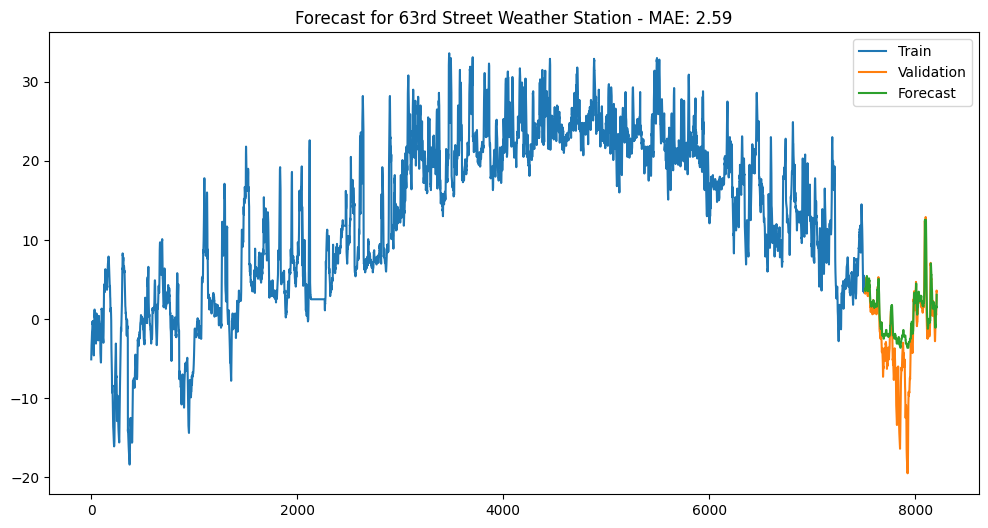

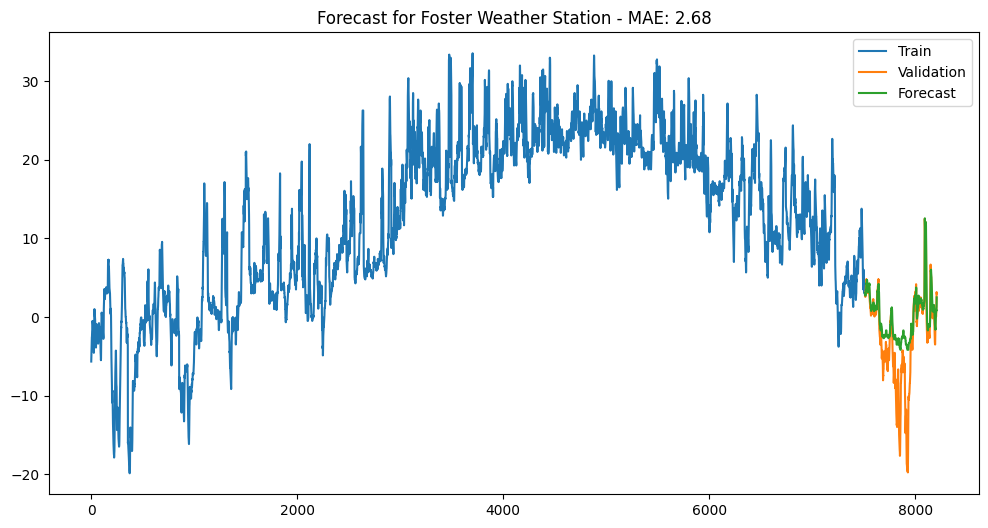

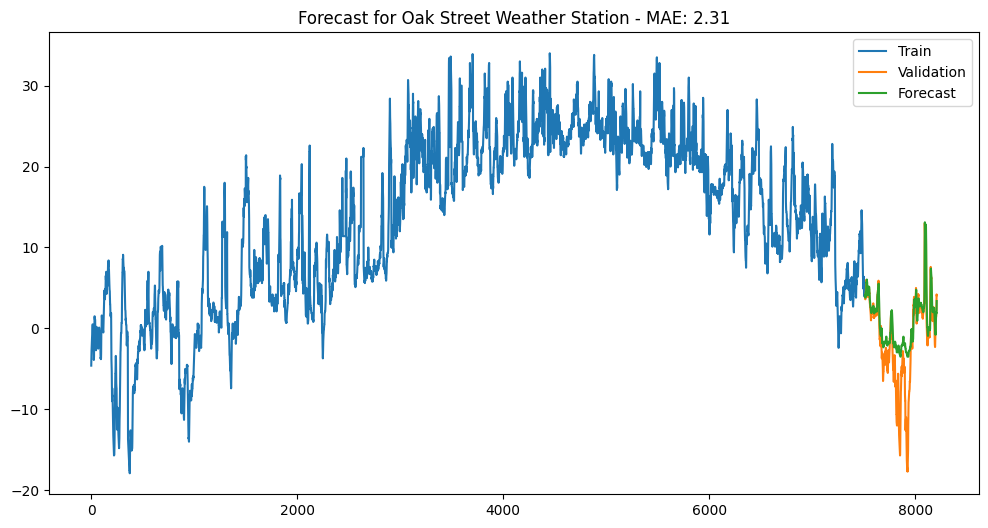

{'63rd Street Weather Station': 2.5890193666443775,
 'Foster Weather Station': 2.677311141708966,
 'Oak Street Weather Station': 2.306383721398796}

In [18]:
# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
forecast_results = {}

for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    model = CatBoostRegressor(loss_function='MAE', iterations=100, silent=True) # the hyperparameters can be tuned
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

mae_scores